# Modern Pandas 8: Scaling

As I sit down to write this, the third-most popular pandas question on StackOverflow covers [how to use pandas for large datasets](https://stackoverflow.com/q/14262433/1889400). This is in tension with the fact that a pandas DataFrame is an in memory container. *You can't have a `DataFrame` larger than your machine's RAM*. In practice, your available RAM should be several times the size of your dataset, as pandas will have to make intermediate copies.

Historically, pandas users have scaled to larger datasets by switching away from pandas or using iteration. Both of these are perfectly valid approaches, but changing your workflow in response to scaling data is unfortunate. I use pandas because it's a pleasant experience, and I would like that experience to scale to larger datasets. That's what [Dask](dask.pydata.org/), a parallel computing library, enables. We'll discuss Dask in detail later. But first, let's work through scaling a simple analysis to a larger than memory dataset.

Our task is to find the 100 most-common occupations reported in the FEC's [individual contributions dataest](https://classic.fec.gov/finance/disclosure/ftpdet.shtml). The files are split by election cycle (2007-2008, 2009-2010, ...). My laptop can read in each cycle's file individually, but the full dataset is too large to read in at once. Let's read in just 2010's file, and do the "small data" version.

In [39]:
from pathlib import Path

import pandas as pd
import seaborn as sns

In [40]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 60
pd.options.display.float_format = lambda s: "{:,.2f}".format(s)

In [41]:
df = pd.read_parquet("data/indiv-10.parq", columns=['occupation'], engine='pyarrow')

most_common = df.occupation.value_counts().nlargest(100)
most_common

RETIRED                    279775
ATTORNEY                   166768
PRESIDENT                   81336
PHYSICIAN                   73015
HOMEMAKER                   66057
                            ...  
C.E.O.                       1945
EMERGENCY PHYSICIAN          1944
BUSINESS EXECUTIVE           1924
BUSINESS REPRESENTATIVE      1879
GOVERNMENT AFFAIRS           1867
Name: occupation, Length: 100, dtype: int64

After reading in the file, our actual analysis is a simple 1-liner using two operations built into pandas. Truly, the best of all possible worlds.

Next, we'll do the analysis for the entire dataset, which is larger than memory, in two ways. First we'll use just pandas and iteration. Then we'll use Dask.

### Using Iteration

To do this with just pandas we have to rewrite our code, taking care to never have too much data in RAM at once. We will

1. Create a global `total_counts` Series that contains the counts from all of the files processed so far
2. Read in a file
3. Compute a temporary variable `counts` with the counts for just this file
4. Add that temporary `counts` into the global `total_counts`
5. Select the 100 largest with `.nlargest`

This works since the `total_counts` Series is relatively small, and each year's data fits in RAM individually. Our peak memory usage should be the size of the largest individual cycle (2015-2016) plus the size of `total_counts` (which we can essentially ignore).

In [42]:
%%time
files = sorted(Path("data/").glob("indiv-*.parq"))

total_counts = pd.Series()

for year in files:
    df = pd.read_parquet(year, columns=['occupation'],
                         engine="pyarrow")
    counts = df.occupation.value_counts()
    total_counts = total_counts.add(counts, fill_value=0)

total_counts = total_counts.nlargest(100).sort_values(ascending=False)
total_counts

CPU times: user 18.9 s, sys: 1.8 s, total: 20.7 s
Wall time: 20.7 s


While this works, our small one-liner has ballooned in size (and complexity; should you *really* have to know about `Series.add`'s `fill_value` parameter for this simple analysis?). If only there was a better way...

### Using Dask

With Dask, we essentially recover our original code. We'll change our import to use `dask.dataframe.read_parquet`, which returns a Dask DataFrame.

In [43]:
import dask.dataframe as dd

In [6]:
%%time
df = dd.read_parquet("data/indiv-*.parq", engine='pyarrow', columns=['occupation'])

most_common = df.occupation.value_counts().nlargest(100)
most_common.compute().sort_values(ascending=False)

CPU times: user 17.8 s, sys: 1.64 s, total: 19.4 s
Wall time: 15.3 s


There are a couple differences from the original pandas version (most notably, this strange `.compute` that we'll discuss next), but overall I hope you agree that the Dask version is nicer than the version using iteration.

## Dask

Now that we've seen `dask.dataframe` in action, let's step back and discuss Dask a bit. Dask is an open-source project that natively parallizes Python. I'm a happy user of and contributor to Dask.

At a high-level, Dask provide familiar APIs for [large N-dimensional arrays](https://dask.pydata.org/en/latest/array.html), [large DataFrames](https://dask.pydata.org/en/latest/dataframe.html), and [familiar](https://distributed.readthedocs.io/en/latest/quickstart.html#map-and-submit-functions) ways to parallelize [custom algorithms](https://dask.pydata.org/en/latest/delayed.html).

At a low-level, each of these is built on high-performance [task scheduling](http://dask.pydata.org/en/latest/scheduling.html) that executes operations in parallel. The [low-level details](http://dask.pydata.org/en/latest/spec.html) aren't too important; all we care about is that

1. Dask works with *task graphs* (*tasks*: functions to call on data, and *graphs*: the relationships between tasks).
2. This is a flexible and performant way to parallelize many different kinds of problems.

To understand point 1, let's examine the difference between a Dask DataFrame and a pandas DataFrame. When we read in `df` with `dd.read_parquet`, we received a Dask DataFrame.

In [7]:
df

,occupation
npartitions=5,
,object
,...
...,...
,...
,...


In [8]:
df

,occupation
npartitions=5,
,object
,...
...,...
,...
,...


A Dask DataFrame consists of many pandas DataFrames arranged by the index. Dask is really just coordinating these many pandas DataFrames. All the actual computation (reading from disk, computing the value counts, etc.) eventually use pandas internally. If I do `df.occupation.str.len`, Dask will coordinate calling `pandas.Series.str.len` on each of the pandas DataFrames.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="50%"/>

Those reading carefully will notice a problem with the statement "A Dask DataFrame consists of many pandas DataFrames". Our initial problem was that we didn't have enough memory for those DataFrames! How can Dask be coordinating DataFrames if there isn't enough memory? This brings us to the second major difference: Dask DataFrames (and arrays) are lazy. Operations on them don't execute and produce the final result immediately. Rather, calling methods on them build up a task graph.

We can visualize task graphs using `graphviz`.

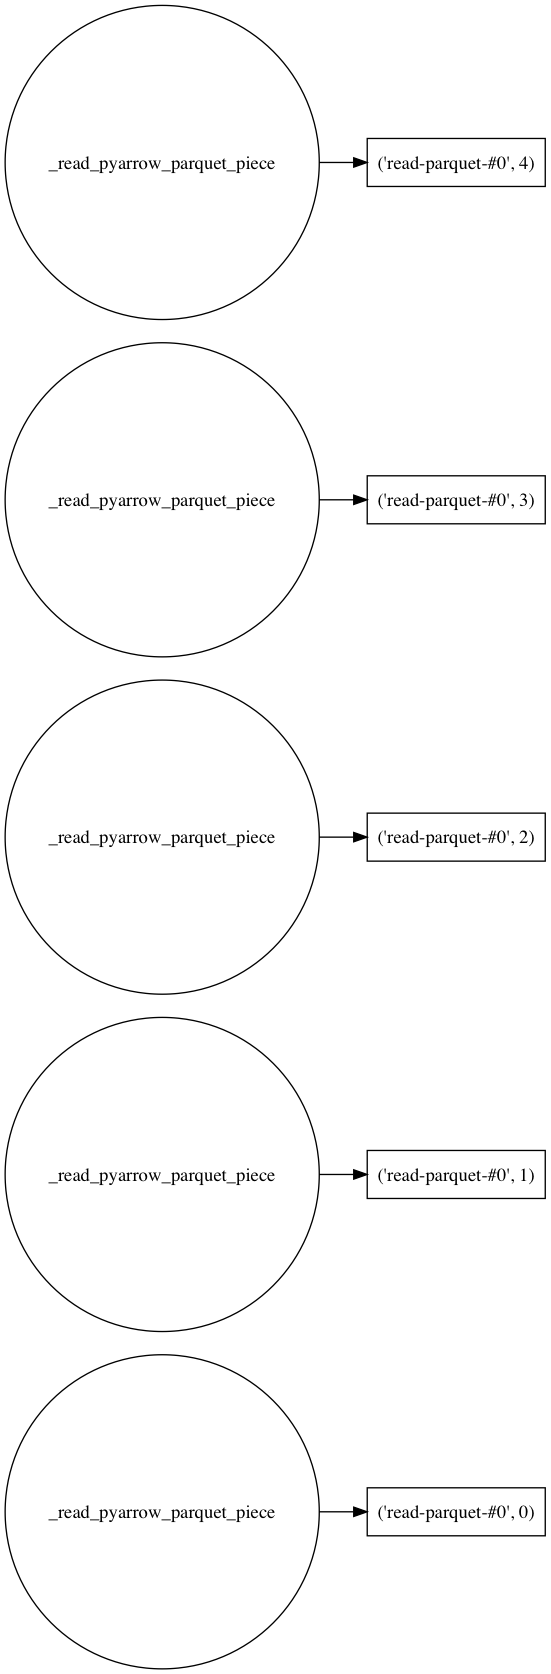

In [9]:
df.visualize(rankdir='LR')

`df` (the dask DataFrame consisting of many pandas DataFrames) has a task graph with 5 calls to a parquet reader (one for each file), each of which produces a DataFrame when called.

Calling additional methods on `df` add additional tasks to this graph. For example, our `most_common` has three additional calls

- Select the `occupation` column (`__getitem__`)
- Perform the value counts
- Select the 100 largest values

In [10]:
most_common = df.occupation.value_counts().nlargest(100)
most_common

Dask Series Structure:
npartitions=1
    int64
      ...
Name: occupation, dtype: int64
Dask Name: series-nlargest-agg, 18 tasks

Which we can visualize.

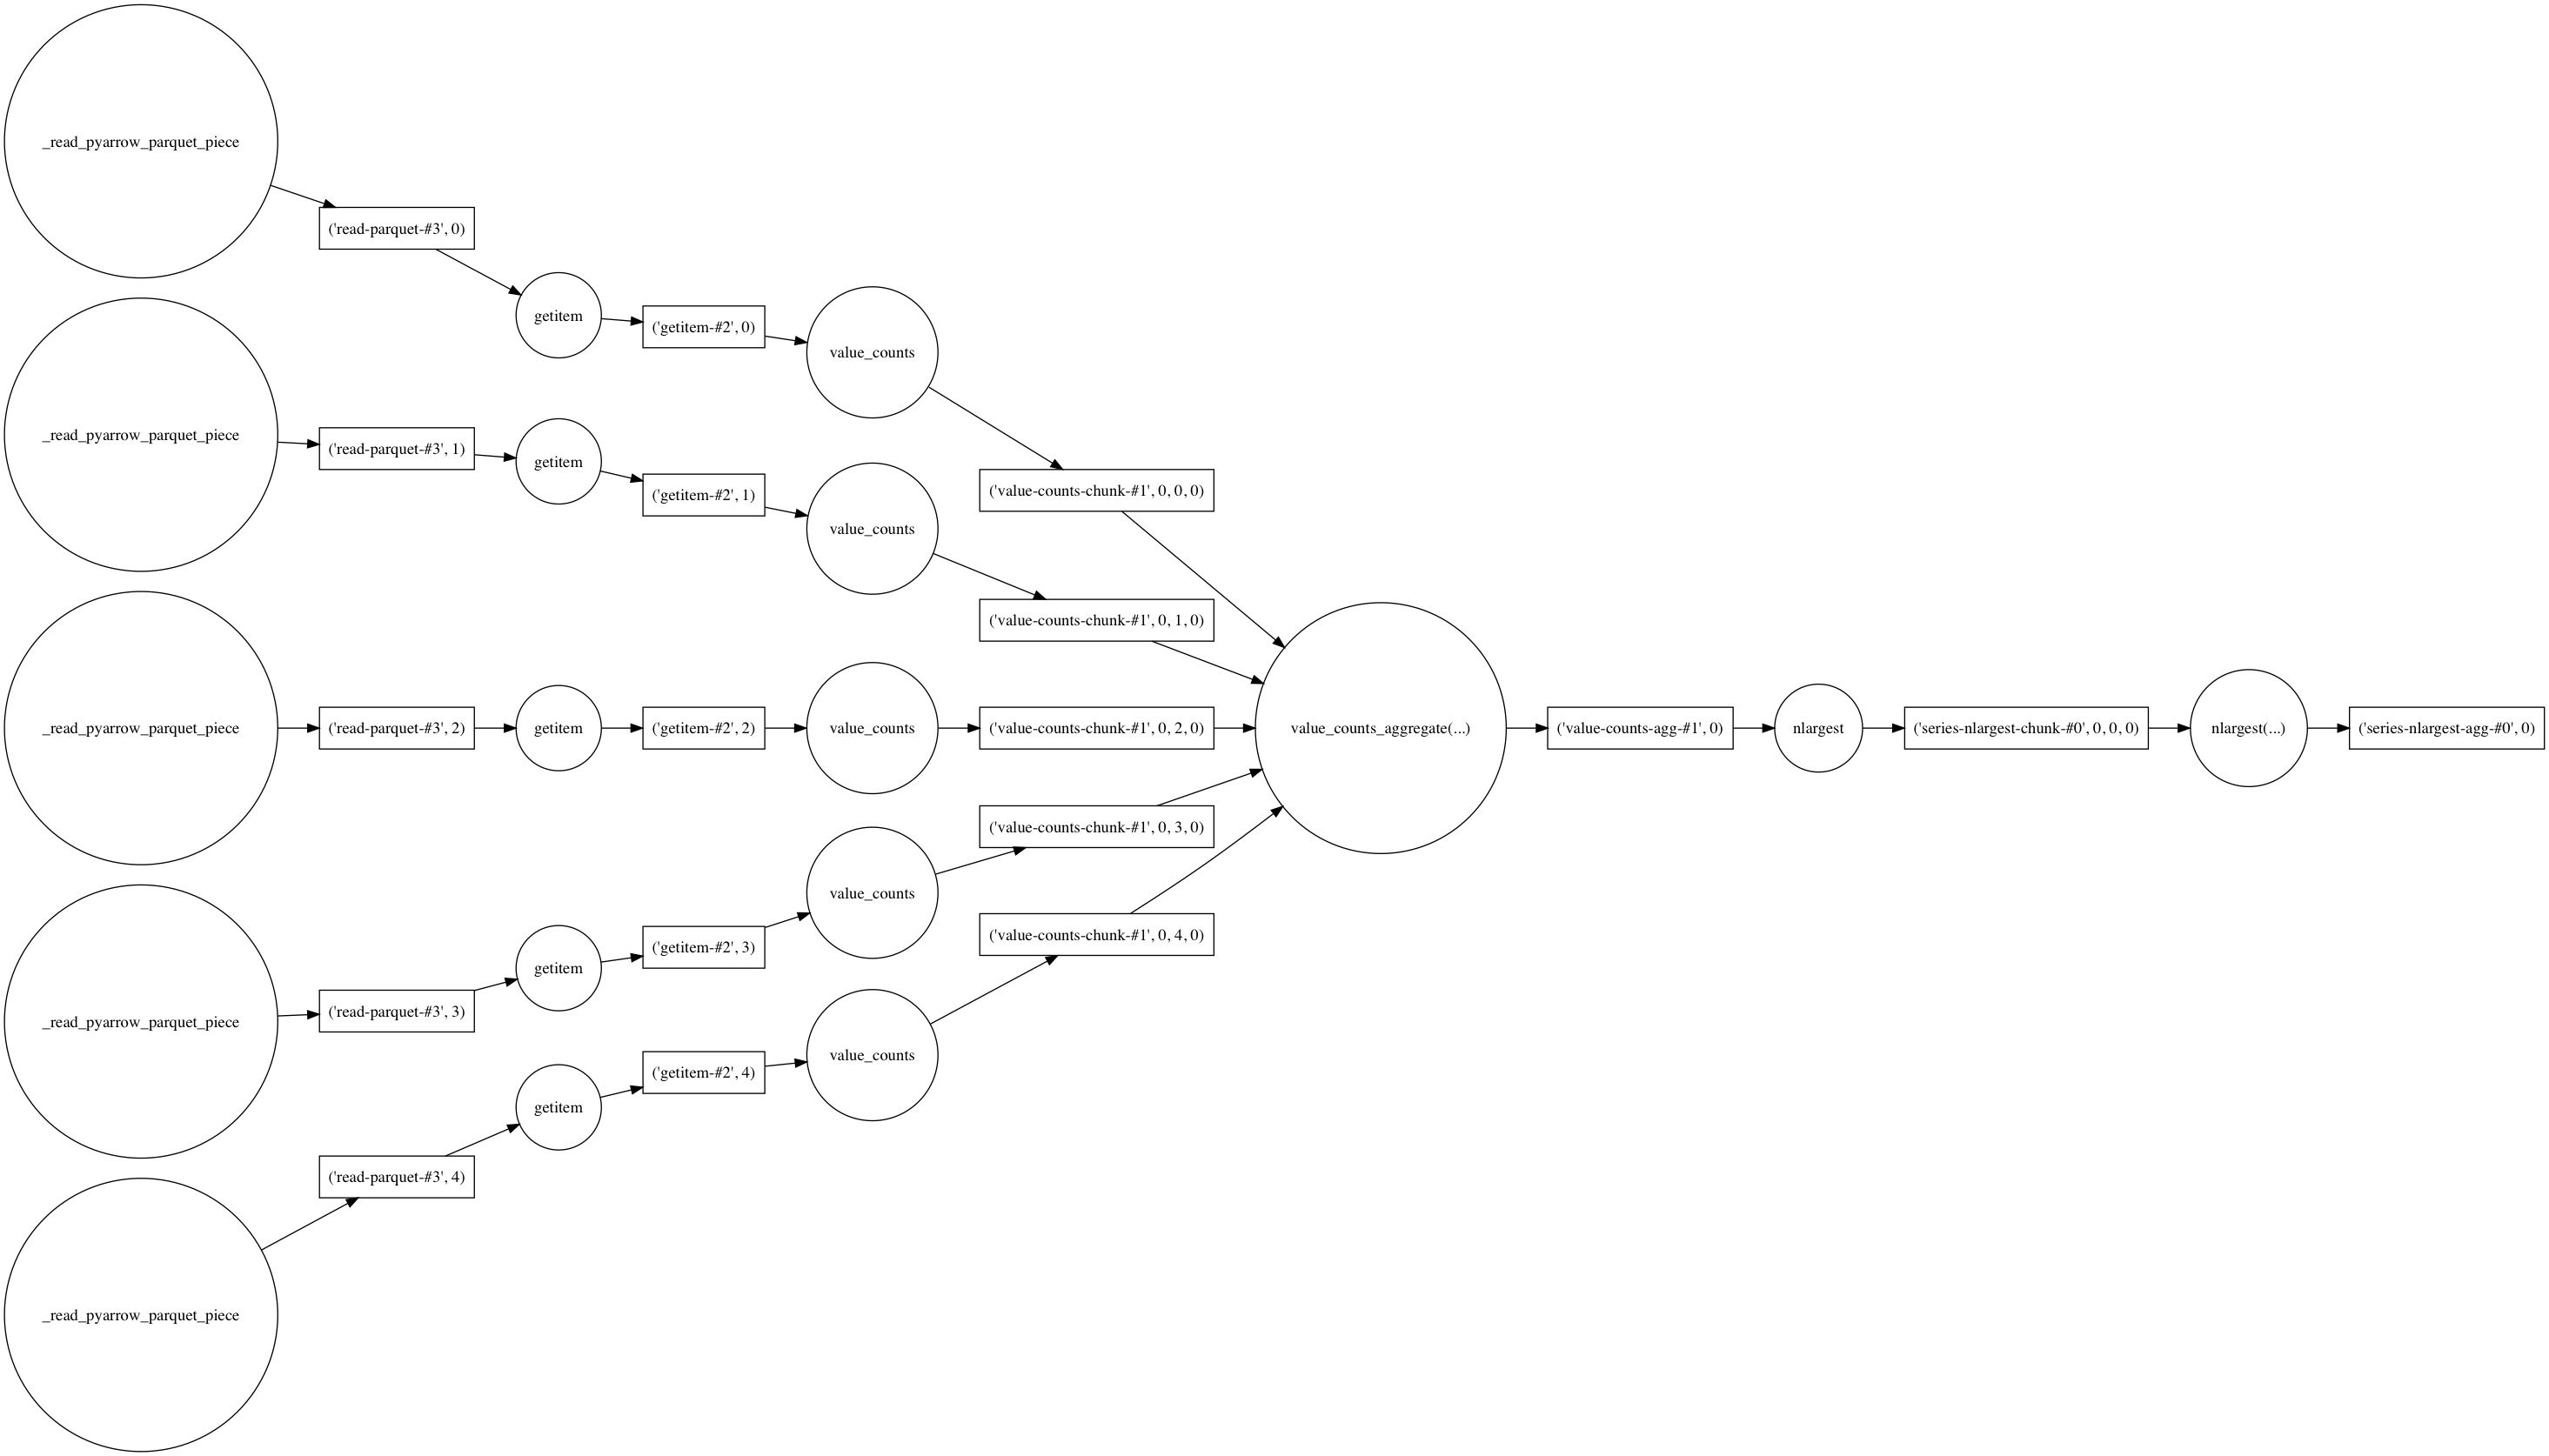

In [11]:
most_common.visualize(rankdir='LR')

So `most_common` doesn't hold the actual answer yet. Instead, it holds a recipe for the answer; a list of all the steps to take to get the concrete result. One way to ask for the result is with the `compute` method.

In [12]:
most_common.compute()

RETIRED                    4769520
NOT EMPLOYED               2656988
ATTORNEY                   1340434
PHYSICIAN                   659082
HOMEMAKER                   494187
                            ...   
CHIEF EXECUTIVE OFFICER      26551
SURGEON                      25521
EDITOR                       25457
OPERATOR                     25151
ORTHOPAEDIC SURGEON          24384
Name: occupation, Length: 100, dtype: int64

At this point, the task graph is handed to a [scheduler](https://dask.pydata.org/en/latest/scheduling.html), which is responsible for executing a task graph. Schedulers can analyze the tasks to be run to discover which tasks can be run *in parallel*. (Dask includes several schedulers. See [the scheduling documentation](http://dask.pydata.org/en/latest/scheduling.html) for how to choose, though Dask has good defaults.)

So that's a high-level tour of how Dask works: 

![](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

1. Various collections collections like `dask.dataframe` and `dask.array`
   provide users familiar APIs for working with large datasets.
2. Computations are represented as a task graph. These graphs could be built by
   hand, or more commonly built by one of the collections.
3. Dask schedulers run task graphs in parallel (potentially distributed across
   a cluster), reusing libraries like NumPy and pandas to do the computations.

Let's finish off this post by continuing to explore the FEC dataset with Dask. At this point, we'll use the distributed scheduler.

In [13]:
import dask.dataframe as dd
from dask import compute
from dask.distributed import Client
import seaborn as sns

client = Client(processes=False)
client

Client Scheduler: inproc://192.168.7.20/56701/1 Dashboard: http://localhost:53899/status,Cluster Workers: 1 Cores: 8 Memory: 17.18 GB


Calling `Client` without providing a scheduler address will make a local cluster of threads or processes on your machine. There are [many ways](http://dask.pydata.org/en/latest/setup.html) to deploy a Dask cluster, though we're particularly fond of [Kubernetes](http://dask.pydata.org/en/latest/setup/kubernetes.html). This highlights one of my favorite features of Dask: it scales down to use a handful of threads on a laptop *or* up to a cluster with thousands of nodes. Dask can comfortably handle medium-sized datasets (dozens of GBs, so larger than RAM) on a laptop. Or it can scale up to very large datasets with a cluster.

In [16]:
individual_cols = ['cmte_id', 'entity_tp', 'employer', 'occupation',
                   'transaction_dt', 'transaction_amt']

indiv = dd.read_parquet('data/indiv-*.parq',
                        columns=individual_cols,
                        engine="pyarrow")
indiv

,cmte_id,entity_tp,employer,occupation,transaction_dt,transaction_amt
npartitions=5,,,,,,
,object,object,object,object,datetime64[ns],int64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


We can compute summary statistics like the average mean and standard deviation of the transaction amount:

In [22]:
avg_transaction = indiv.transaction_amt.mean()

We can answer questions like "Which employer's employees donated the most?"

In [23]:
total_by_employee = (
    indiv.groupby('employer')
        .transaction_amt.sum()
        .nlargest(10)
)

Or "what is the average amount donated per occupation?"

In [24]:
avg_by_occupation = (
    indiv.groupby("occupation")
        .transaction_amt.mean()
        .nlargest(10)
)

Since Dask is lazy, we haven't actually computed anything.

In [25]:
total_by_employee

Dask Series Structure:
npartitions=1
    int64
      ...
Name: transaction_amt, dtype: int64
Dask Name: series-nlargest-agg, 13 tasks

`avg_transaction`, `avg_by_occupation` and `total_by_employee` are three separate computations (they have different task graphs), but we know they share some structure: they're all reading in the same data, they might select the same subset of columns, and so on. Dask is able to avoid redundant computation when you use the top-level `dask.compute` function.

In [26]:
%%time
avg_transaction, by_employee, by_occupation = compute(
    avg_transaction, total_by_employee, avg_by_occupation
)

CPU times: user 1min, sys: 23.2 s, total: 1min 23s
Wall time: 1min 6s


In [27]:
avg_transaction

566.0899206077507

In [28]:
by_employee

employer
RETIRED                1019973117
SELF-EMPLOYED           834547641
SELF                    537402882
SELF EMPLOYED           447363032
NONE                    418011322
HOMEMAKER               355195126
NOT EMPLOYED            345770418
FAHR, LLC               166679844
CANDIDATE                75186830
ADELSON DRUG CLINIC      53358500
Name: transaction_amt, dtype: int64

In [29]:
by_occupation

occupation
CHAIRMAN CEO & FOUNDER                   1,023,333.33
PAULSON AND CO., INC.                    1,000,000.00
CO-FOUNDING DIRECTOR                       875,000.00
CHAIRMAN/CHIEF TECHNOLOGY OFFICER          750,350.00
CO-FOUNDER, DIRECTOR, CHIEF INFORMATIO     675,000.00
CO-FOUNDER, DIRECTOR                       550,933.33
MOORE CAPITAL GROUP, LP                    500,000.00
PERRY HOMES                                500,000.00
OWNER, FOUNDER AND CEO                     500,000.00
CHIEF EXECUTIVE OFFICER/PRODUCER           500,000.00
Name: transaction_amt, dtype: float64

Things like filtering work well. Let's find the 10 most common occupations and filter the dataset down to just those.

In [30]:
top_occupations = (
    indiv.occupation.value_counts()
        .nlargest(10).index
).compute()
top_occupations

Index(['RETIRED', 'NOT EMPLOYED', 'ATTORNEY', 'PHYSICIAN', 'HOMEMAKER',
       'PRESIDENT', 'PROFESSOR', 'CONSULTANT', 'EXECUTIVE', 'ENGINEER'],
      dtype='object')

We'll filter the raw records down to just the ones from those occupations. Then we'll compute a few summary statistics on the transaction amounts for each group.

In [31]:
donations = (
    indiv[indiv.occupation.isin(top_occupations)]
        .groupby("occupation")
        .transaction_amt
        .agg(['count', 'mean', 'sum', 'max'])
)

In [32]:
total_avg, occupation_avg = compute(indiv.transaction_amt.mean(),
                                    donations['mean'])

These are small, concrete results so we can turn to familiar tools like matplotlib to visualize the result.

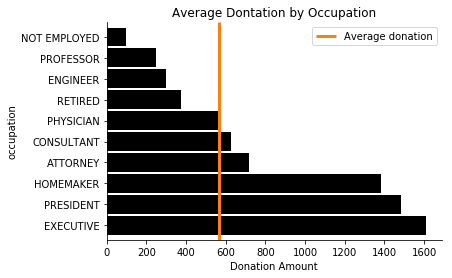

In [33]:
ax = occupation_avg.sort_values(ascending=False).plot.barh(color='k', width=0.9);
lim = ax.get_ylim()
ax.vlines(total_avg, *lim, color='C1', linewidth=3)
ax.legend(['Average donation'])
ax.set(xlabel="Donation Amount", title="Average Dontation by Occupation")
sns.despine()

Dask inherits all of pandas' great time-series support. We can get the total amount donated per day using a [`resample`](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling).

In [34]:
daily = (
    indiv[['transaction_dt', 'transaction_amt']].dropna()
        .set_index('transaction_dt')['transaction_amt']
        .resample("D")
        .sum()
).compute()
daily

1916-01-23    1000
1916-01-24       0
1916-01-25       0
1916-01-26       0
1916-01-27       0
              ... 
2201-05-29       0
2201-05-30       0
2201-05-31       0
2201-06-01       0
2201-06-02    2000
Name: transaction_amt, Length: 104226, dtype: int64

It seems like we have some bad data. This should just be 2007-2016. We'll filter it down to the real subset before plotting.

In [35]:
subset = daily.loc['2011':'2016']

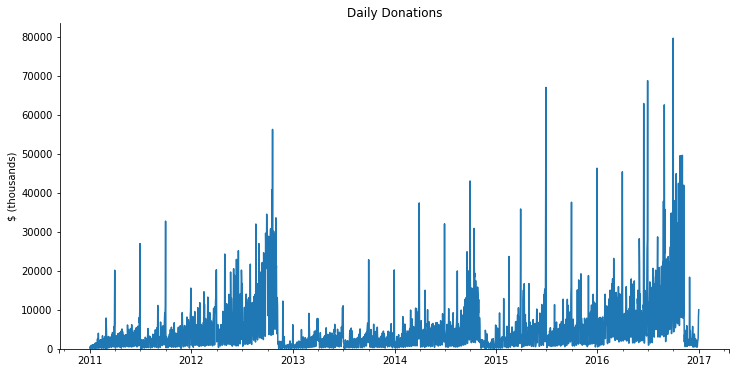

In [36]:
ax = subset.div(1000).plot(figsize=(12, 6))
ax.set(ylim=0, title="Daily Donations", ylabel="$ (thousands)",)
sns.despine();

## Joining

Like pandas, Dask supports joining together multiple datasets.

Individual donations are made to *committees*. Committees are what make the actual expenditures (buying a TV ad).
Some committees are directly tied to a candidate (this are campaign committees). Other committees are tied to a group (like the Republican National Committee). Either may be tied to a party.

Let's read in the committees:

In [37]:
committee_cols = ['cmte_id', 'cmte_nm', 'cmte_tp', 'cmte_pty_affiliation']
cm = dd.read_parquet("data/cm-*.parq",
                     columns=committee_cols).compute()

# Some committees change thier name, but the ID stays the same
cm = cm.groupby('cmte_id').last()
cm

,cmte_nm,cmte_tp,cmte_pty_affiliation
cmte_id,,,
C00000042,ILLINOIS TOOL WORKS INC. FOR BETTER GOVERNMENT...,Q,NaN
C00000059,HALLMARK CARDS PAC,Q,UNK
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,Q,NaN
C00000489,D R I V E POLITICAL FUND CHAPTER 886,N,NaN
C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,Q,UNK
...,...,...,...
C90017237,ORGANIZE NOW,I,NaN
C90017245,FRANCISCO AGUILAR,I,NaN
C90017336,"LUDWIG, EUGENE",I,NaN


We'll use `dd.merge`, which is analogous to `pd.merge` for joining a Dask `DataFrame` with a pandas or Dask `DataFrame`.

In [38]:
indiv = indiv[(indiv.transaction_dt >= pd.Timestamp("2007-01-01")) &
              (indiv.transaction_dt <= pd.Timestamp("2018-01-01"))]

df2 = dd.merge(indiv, cm.reset_index(), on='cmte_id')
df2

,cmte_id,entity_tp,employer,occupation,transaction_dt,transaction_amt,cmte_nm,cmte_tp,cmte_pty_affiliation
npartitions=5,,,,,,,,,
,object,object,object,object,datetime64[ns],int64,object,object,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


Now we can find which party raised more over the course of each election. We'll group by the day and party and sum the transaction amounts.

In [53]:
indiv = indiv.repartition(npartitions=10)
df2 = dd.merge(indiv, cm.reset_index(), on='cmte_id')
df2

,cmte_id,entity_tp,employer,occupation,transaction_dt,transaction_amt,cmte_nm,cmte_tp,cmte_pty_affiliation
npartitions=10,,,,,,,,,
,object,object,object,object,datetime64[ns],int64,object,object,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [ ]:
party_donations = (
    df2.groupby([df2.transaction_dt, 'cmte_pty_affiliation'])
       .transaction_amt.sum()
).compute().sort_index()

We'll filter that down to just Republican and Democrats and plot.

In [ ]:
ax = (
    party_donations.loc[:, ['REP', 'DEM']]
        .unstack("cmte_pty_affiliation").iloc[1:-2]
        .rolling('30D').mean().plot(color=['C0', 'C3'], figsize=(12, 6),
                                    linewidth=3)
)
sns.despine()
ax.set(title="Daily Donations (30-D Moving Average)", xlabel="Date");

## Try It Out!

So that's a taste of Dask. Next time you hit a scaling problem with pandas (or NumPy, scikit-learn, or your custom code), feel free to

```
pip install dask[complete]
```

or

```
conda install dask
```

The [dask homepage](http://dask.pydata.org/en/latest/) has links to all the relevant documentation, and [binder notebooks](https://mybinder.org/v2/gh/dask/dask-examples/master?filepath=dataframe.ipynb) where you can try out Dask before installing.

As always, reach out to me on [Twitter](https://twitter.com/TomAugspurger) or in the comments if you have anything to share.